In [3]:
import os
import pandas as pd
import numpy as np
import earthpy as et

In [4]:
curr_timespan = '2014to2023'

fire_dir = os.path.join(et.io.HOME, 'earth-analytics', 'EA_fire_project')
data_dir = os.path.join(fire_dir, 'data')
out_dir = os.path.join(data_dir, 'original')
tmp_dir = os.path.join(data_dir, 'processed')

In [5]:
df = pd.read_csv(os.path.join(out_dir,
                                  'SIT209_HISTORY_INCIDENT_209_REPORTS_{}_cleaned.csv'.format(curr_timespan)), 
                     parse_dates=True,
                     low_memory=False)
# Remove unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [6]:
df['PCT_CONTAINED_COMPLETED']

0         100.0
1          99.0
2           0.0
3           0.0
4           0.0
          ...  
100584      0.0
100585     60.0
100586     80.0
100587     80.0
100588    100.0
Name: PCT_CONTAINED_COMPLETED, Length: 100589, dtype: float64

In [7]:
columns = ['INCIDENT_ID',
           'INC209R_IDENTIFIER',
           'REPORT_TO_DATE',
           'CURRENT_THREAT_12',
           'CURRENT_THREAT_24',
           'CURRENT_THREAT_48',
           'CURRENT_THREAT_72',
           'CURRENT_THREAT_GT72',
           'CURRENT_THREAT_NARR',
           'STR_THREATENED_RES',
           'STR_THREATENED',
           'STR_DESTROYED',
           'LIFE_SAFETY_HEALTH_STATUS_NARR',
           'PCT_CONTAINED_COMPLETED']
# create a subset of the data
dfsub = df.loc[
    df.INCIDENT_ID.isin(
        ['2021_12993824_DIXIE','2021_12908560_CALDOR'])][columns].copy()
# Fill empty values with ''
collist = ['CURRENT_THREAT_12',
           'CURRENT_THREAT_24',
           'CURRENT_THREAT_48',
           'CURRENT_THREAT_72',
           'CURRENT_THREAT_GT72']
dfsub[collist] = dfsub[collist].fillna('')

In [8]:
df_norepeat = dfsub.copy()

for col in collist:
    # create a new column that shifts the current column down by one row
    df_norepeat['shifted'] = df_norepeat[col].shift(1)
    
    # Compare the current column with 'shifted'.
    new_col_name = f'unrepeated_{col}'
    df_norepeat[new_col_name] = (
        df_norepeat.apply(lambda row: 'same' if row[col] == row['shifted'] else row[col],
                    axis=1)
    )
    
    # Drop the temporary 'shifted' column after use
    df_norepeat.drop(columns=['shifted'], inplace=True)

In [9]:
df_norepeat['REPORT_TO_DATE']

# Convert 'REPORT_TO_DATE' to datetime format
df_norepeat['REPORT_TO_DATE'] = pd.to_datetime(df_norepeat['REPORT_TO_DATE'])

# Sort the DataFrame by 'REPORT_TO_DATE'
df_norepeat = df_norepeat.sort_values('REPORT_TO_DATE')

# Calculate the difference in hours and add as a new column
df_norepeat['last_reported'] = df_norepeat['REPORT_TO_DATE'].diff().dt.total_seconds() / 3600

<Axes: title={'center': 'Time between reports (hours)'}, ylabel='Frequency'>

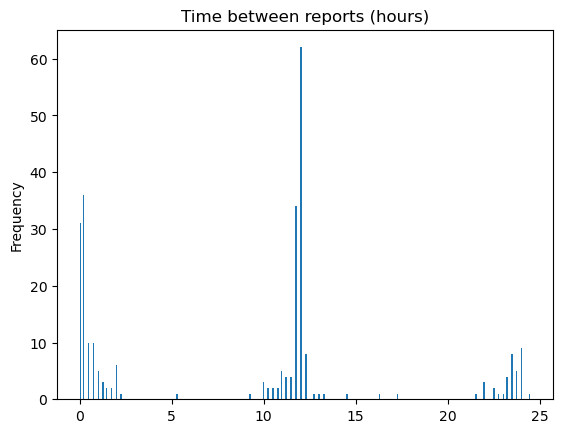

In [10]:
# time between reports in general
# could also be interesteing time between new 12 hours threats
# 12 hours threat has the least uncertainty? 12 hour lead time?
df_norepeat['last_reported'].plot(kind='hist', bins= len(df_norepeat), title='Time between reports (hours)')

In [11]:
df_norepeat.to_csv(os.path.join(tmp_dir,'dixie-caldor-no_repeat.csv'),index=False)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\lucap\\earth-analytics\\EA_fire_project\\data\\processed\\dixie-caldor-no_repeat.csv'

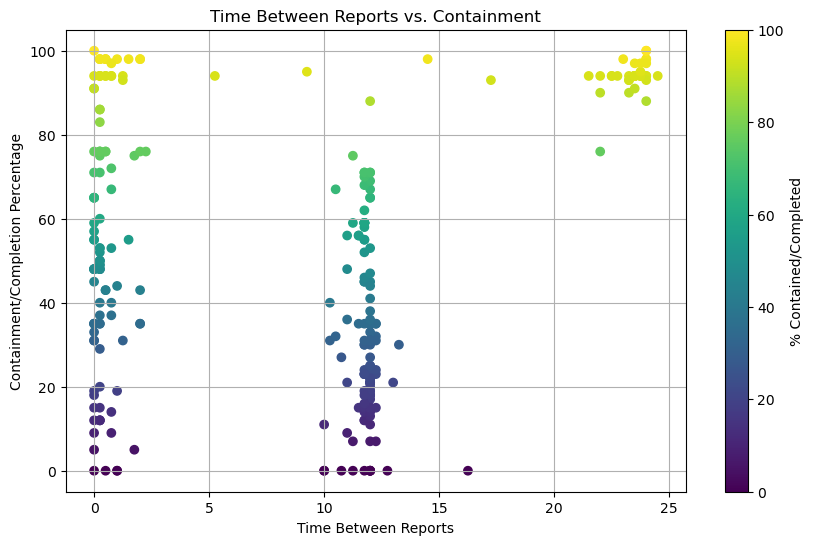

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame and it has columns 'time_between_reports' and 'final_fire_size'
# Load your data into a DataFrame
# df = pd.read_csv('your_data.csv')  # Uncomment and modify this line as necessary

# Ensure the data is numeric (this step may vary depending on your data)
df_norepeat['last_reported'] = pd.to_numeric(df_norepeat['last_reported'], errors='coerce')
df_norepeat['PCT_CONTAINED_COMPLETED'] = pd.to_numeric(df_norepeat['PCT_CONTAINED_COMPLETED'], errors='coerce')

# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
scatter = plt.scatter(df_norepeat['last_reported'],
                      df_norepeat['PCT_CONTAINED_COMPLETED'], 
                      c=df_norepeat['PCT_CONTAINED_COMPLETED'], cmap='viridis')

# Add a color bar
plt.colorbar(scatter, label='% Contained/Completed')

# Customize the plot
plt.xlabel('Time Between Reports')
plt.ylabel('Containment/Completion Percentage')
plt.title('Time Between Reports vs. Containment')
plt.grid(True)  # Optional: Adds a grid for easier visualization

# Show the plot
plt.show()

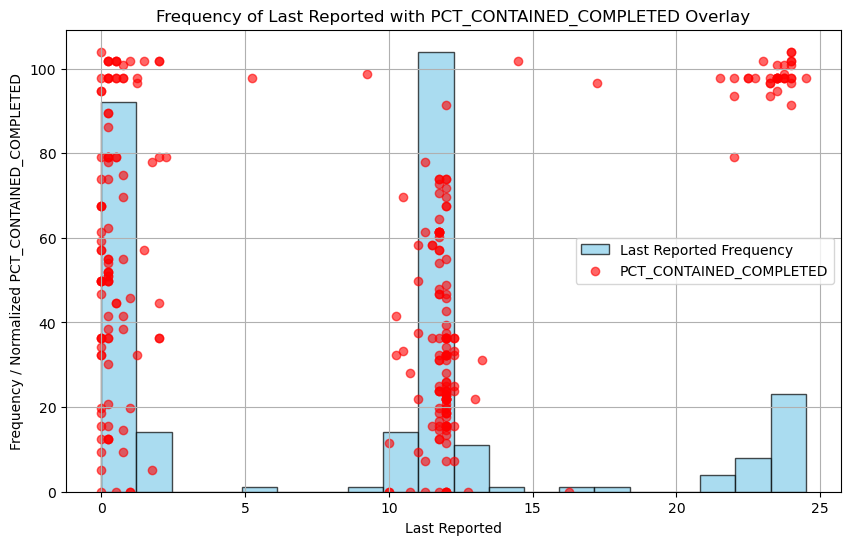

In [ ]:
import numpy as np

# Create the histogram for 'last_reported'
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_norepeat['last_reported'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='Last Reported Frequency')

# Normalize 'PCT_CONTAINED_COMPLETED' to match the histogram's y-axis scale
# This step is crucial to overlaying the scatter plot meaningfully on the histogram
max_height = max(n)  # Maximum frequency in the histogram
normalized_pct = (df_norepeat['PCT_CONTAINED_COMPLETED'] / df_norepeat['PCT_CONTAINED_COMPLETED'].max()) * max_height

# Create the scatter plot overlay
plt.scatter(df_norepeat['last_reported'], normalized_pct, color='red', label='PCT_CONTAINED_COMPLETED', alpha=0.6)

# Customize the plot
plt.xlabel('Last Reported')
plt.ylabel('Frequency / Normalized PCT_CONTAINED_COMPLETED')
plt.title('Frequency of Last Reported with PCT_CONTAINED_COMPLETED Overlay')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Calculate the percentage of repeated/unrepeated values
(df_norepeat['unrepeated_CURRENT_THREAT_12'] == 'same').sum() / len(df_norepeat)
(df_norepeat['unrepeated_CURRENT_THREAT_12'] != 'same').sum() / len(df_norepeat)

0.45652173913043476

In [ ]:
dft = dfsub.copy()
# strip spaces
for col in collist:
    dft[col] = df[col].str.strip()

# initialize appended to False and consolidated narrative to empty string
dft['CURRENT_THREAT_NARR2'] = ''
for col in collist:
    time_frame = col.split('_')[-1]
    # strip to make sure not null
    if time_frame == '12':
        # initialize processed content
        dft.loc[dft[col] != '','prev_narr'] = dft['CURRENT_THREAT_12']
        dft.loc[dft[col] != '','time_label'] = time_frame
    else: 
        # later time_frame
        # equal to previous narrative - add time to time label
        dft.loc[
            (dft[col] != '') & (dft[col].str.lower() == dft['prev_narr'].str.lower()),
            'time_label'
            ]= dft.time_label + '/' + time_frame
        # not equal - append and re-initialize
        dft.loc[
            ((dft[col] != '') & (dft[col].str.lower() != dft['prev_narr'].str.lower())),
            'CURRENT_THREAT_NARR2'
            ] = dft.CURRENT_THREAT_NARR2 + \
                "\n" + dft.time_label + " Hours: " + \
                dft.prev_narr
        dft.loc[
            (dft[col] != '') & (dft[col].str.lower() != dft['prev_narr'].str.lower()),
            'time_label'
            ] = time_frame
        dft.loc[
            (dft[col] != '') & (dft[col].str.lower() != dft['prev_narr'].str.lower()),
            'prev_narr'
            ] = dft[col]
# format narrative with time label
dft['CURRENT_THREAT_NARR2'] = (
    dft.CURRENT_THREAT_NARR2 + "\n" + \
    dft.time_label + " Hours: " + dft.prev_narr)
dft['CURRENT_THREAT_NARR2'] = dft.CURRENT_THREAT_NARR2.str.strip()
        

dft.to_csv(os.path.join(tmp_dir,'dixie-caldor-threat.csv'),index=False)

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load your data
data = pd.read_csv(os.path.join(tmp_dir,'dixie-caldor-threat.csv'))
narratives = data[data['INCIDENT_ID'] == '2021_12908560_CALDOR']['CURRENT_THREAT_NARR2'].fillna('')

# Preprocess text: convert to lower case, remove special characters, and remove stop words
stop_words = set(['and', 'the', 'of', 'to', 'in', 'is', 'a', 'for', 'are', 'that', 'with', 'as', 'on', 'this', 'at', 'from', 'by', 'an', 'be', 'it'])

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return ' '.join([word for word in text.split() if word not in stop_words])

cleaned_narratives = narratives.apply(preprocess_text)

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(cleaned_narratives)

# Train the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# Display the top words for each topic
n_top_words = 10
words = vectorizer.get_feature_names_out()
topics = []

for topic_idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    topics.append(top_words)

for idx, topic in enumerate(topics):
    print(f"Topic #{idx + 1}: {', '.join(topic)}")


Topic #1: infrastructure, california, frog, nevada, remains, including, perimeter, threat, gt, yellowlegged
Topic #2: natural, cultural, critical, watershed, equipment, values, impacts, pge, low, high
Topic #3: soil, frequently, steep, creating, slides, severity, slopes, mud, flows, areas
Topic #4: water, dorado, threatened, el, sierra, critical, resources, sites, impacted, district
Topic #5: lake, threatened, water, tahoe, impacted, critical, dorado, el, sites, district


In [13]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load your data
data = pd.read_csv(os.path.join(tmp_dir,'dixie-caldor-threat.csv'))
narratives = data[data['INCIDENT_ID'] == '2021_12993824_DIXIE']['CURRENT_THREAT_12'].fillna('')

# Preprocess text: convert to lower case, remove special characters, and remove stop words
stop_words = set(['and', 'the', 'of', 'to', 'in', 'is', 'a', 'for', 'are', 'that', 'with', 'as', 'on', 'this', 'at', 'from', 'by', 'an', 'be', 'it'])

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return ' '.join([word for word in text.split() if word not in stop_words])

cleaned_narratives = narratives.apply(preprocess_text)

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(cleaned_narratives)

# Train the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# Display the top words for each topic
n_top_words = 10
words = vectorizer.get_feature_names_out()
topics = []

for topic_idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    topics.append(top_words)

for idx, topic in enumerate(topics):
    print(f"Topic #{idx + 1}: {', '.join(topic)}")


Topic #1: lake, river, drains, creek, communities, downstream, sacramento, lassen, station, species
Topic #2: valley, lake, california, frog, river, risk, including, trail, almanor, feather
Topic #3: moderate, jellico, halls, old, communities, hat, chester, hotter, box, dryer
Topic #4: pacific, valley, lake, cabin, river, feather, northern, creek, site, major
Topic #5: cabin, creek, flat, species, springs, threatened, reese, shacks, cemeteries, cow


In [14]:
import pandas as pd
import spacy

# # Load your data
# data = pd.read_csv('your_file_path.csv')

# Preprocess text function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Apply preprocessing
data['CURRENT_THREAT_12'] = data['CURRENT_THREAT_12'].fillna('').apply(preprocess_text)

# Split data by INCIDENT_ID
incident_ids = data['INCIDENT_ID'].unique()
data_by_incident = {incident_id: data[data['INCIDENT_ID'] == incident_id]['CURRENT_THREAT_12'].tolist() for incident_id in incident_ids}

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Perform NER and collect results
ner_results = {}
for incident_id, texts in data_by_incident.items():
    entities = []
    for text in texts:
        doc = nlp(text)
        for ent in doc.ents:
            entities.append((ent.text, ent.label_))
    ner_results[incident_id] = entities

# Print NER results for each INCIDENT_ID
for incident_id, entities in ner_results.items():
    print(f"Entities for {incident_id}:")
    for entity in entities:
        print(f" - {entity[0]} ({entity[1]})")
    print("\n")


Entities for 2021_12908560_CALDOR:
 - california (GPE)
 - native american (PERSON)
 - california (GPE)
 - native american (PERSON)
 - california (GPE)
 - native american (PERSON)
 - california (GPE)
 - american (NORP)
 - camino cedar groveprivate (PERSON)
 - sierra pacific industries vineyards (ORG)
 - el dorado county (GPE)
 - thousands (CARDINAL)
 - el dorado (GPE)
 - el dorado (GPE)
 - power house (ORG)
 - california (GPE)
 - native american (NORP)
 - camino cedar groveprivate (PERSON)
 - sierra pacific industries vineyards (ORG)
 - el dorado county (GPE)
 - thousands (CARDINAL)
 - el dorado (GPE)
 - el dorado (GPE)
 - power house (ORG)
 - california (GPE)
 - native american (NORP)
 - el dorado county (GPE)
 - thousands (CARDINAL)
 - el dorado (GPE)
 - el dorado (GPE)
 - power house (ORG)
 - el dorado (GPE)
 - resa (PERSON)
 - el dorado (GPE)
 - native american (NORP)
 - foothill yellowlegged frog (ORG)
 - california (GPE)
 - sierra nevada (ORG)
 - sierra nevada (ORG)
 - sierra paci

In [16]:
# Preprocess text function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Apply preprocessing
data['CURRENT_THREAT_12'] = data['CURRENT_THREAT_12'].fillna('').apply(preprocess_text)

# Split data by INCIDENT_ID
incident_ids = data['INCIDENT_ID'].unique()
data_by_incident = {
    incident_id: data[data['INCIDENT_ID'] == incident_id]['CURRENT_THREAT_12'].tolist()
    for incident_id in incident_ids}

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Perform NER and collect results in a DataFrame
ner_results = []

for incident_id, texts in data_by_incident.items():
    for text in texts:
        doc = nlp(text)
        for ent in doc.ents:
            ner_results.append({'INCIDENT_ID': incident_id, 'Entity': ent.text, 'Label': ent.label_})

ner_df = pd.DataFrame(ner_results)

# Save the results to a CSV file
ner_df.to_csv(os.path.join(tmp_dir,'ner_results.csv'), index=False)

# Display the DataFrame
print(ner_df.head())


            INCIDENT_ID           Entity   Label
0  2021_12908560_CALDOR       california     GPE
1  2021_12908560_CALDOR  native american  PERSON
2  2021_12908560_CALDOR       california     GPE
3  2021_12908560_CALDOR  native american  PERSON
4  2021_12908560_CALDOR       california     GPE


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   INCIDENT_ID  5329 non-null   object
 1   Entity       5329 non-null   object
 2   Label        5329 non-null   object
dtypes: object(3)
memory usage: 125.0+ KB
None
            INCIDENT_ID           Entity   Label
0  2021_12908560_CALDOR       california     GPE
1  2021_12908560_CALDOR  native american  PERSON
2  2021_12908560_CALDOR       california     GPE
3  2021_12908560_CALDOR  native american  PERSON
4  2021_12908560_CALDOR       california     GPE
Number of entities per INCIDENT_ID:
INCIDENT_ID
2021_12908560_CALDOR    1136
2021_12993824_DIXIE     4193
dtype: int64

Most common entities:
Entity
sacramento             406
california             264
day                    162
reese                  162
el dorado              155
three                  145
northern california    137
san franci

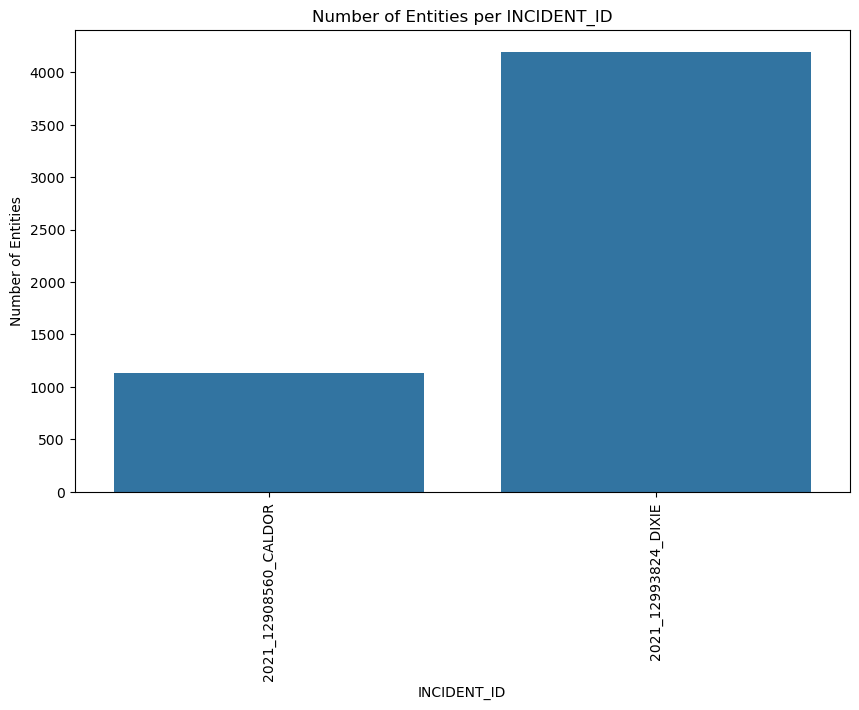

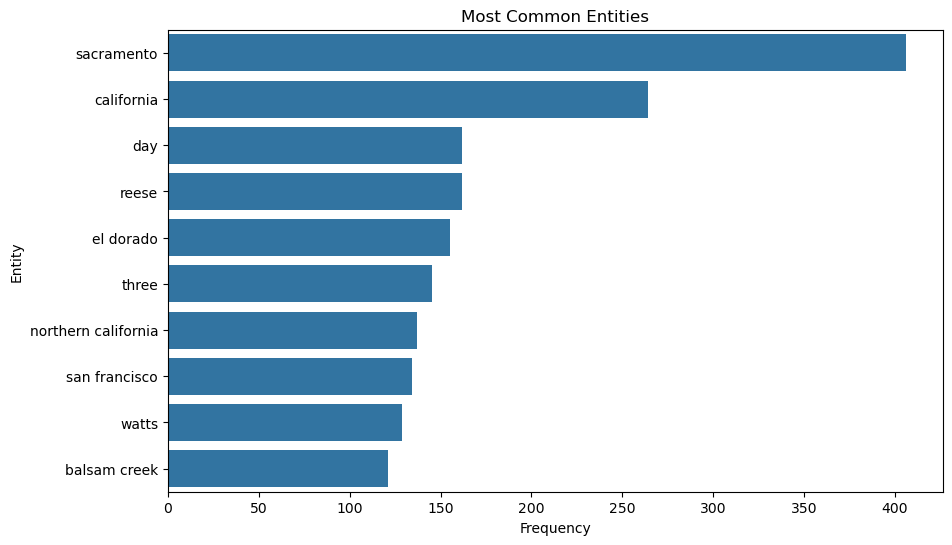

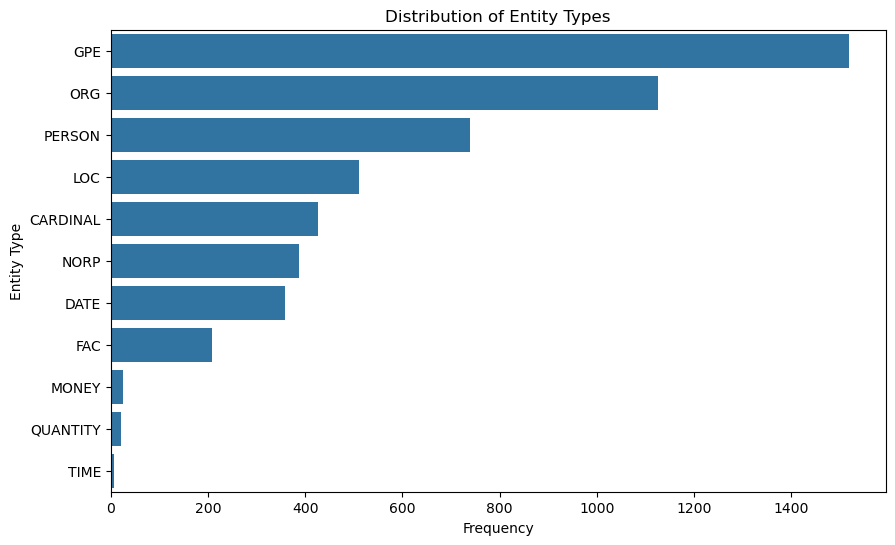

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the NER results
ner_df = pd.read_csv('ner_results.csv')

# Display basic information about the data
print(ner_df.info())
print(ner_df.head())

# Summary Statistics

# Number of entities per INCIDENT_ID
entities_per_incident = ner_df.groupby('INCIDENT_ID').size()
print("Number of entities per INCIDENT_ID:")
print(entities_per_incident)

# Most common entities
most_common_entities = ner_df['Entity'].value_counts().head(10)
print("\nMost common entities:")
print(most_common_entities)

# Distribution of entity types
entity_type_distribution = ner_df['Label'].value_counts()
print("\nDistribution of entity types:")
print(entity_type_distribution)

# Visualization

# Bar plot of number of entities per INCIDENT_ID
plt.figure(figsize=(10, 6))
sns.barplot(x=entities_per_incident.index, y=entities_per_incident.values)
plt.title('Number of Entities per INCIDENT_ID')
plt.xlabel('INCIDENT_ID')
plt.ylabel('Number of Entities')
plt.xticks(rotation=90)
plt.show()

# Bar plot of the most common entities
plt.figure(figsize=(10, 6))
sns.barplot(x=most_common_entities.values, y=most_common_entities.index)
plt.title('Most Common Entities')
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.show()

# Bar plot of the distribution of entity types
plt.figure(figsize=(10, 6))
sns.barplot(x=entity_type_distribution.values, y=entity_type_distribution.index)
plt.title('Distribution of Entity Types')
plt.xlabel('Frequency')
plt.ylabel('Entity Type')
plt.show()


Most common GPE entities:
Entity
sacramento          406
california          264
el dorado           155
san francisco       134
susanville           76
johnstonville        75
mill creek           75
janesville           70
el dorado county     69
nevada               54
Name: count, dtype: int64


C:\Users\lucap\AppData\Local\Temp\ipykernel_51128\3129720691.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gpe_counts.values, y=gpe_counts.index, palette='viridis')


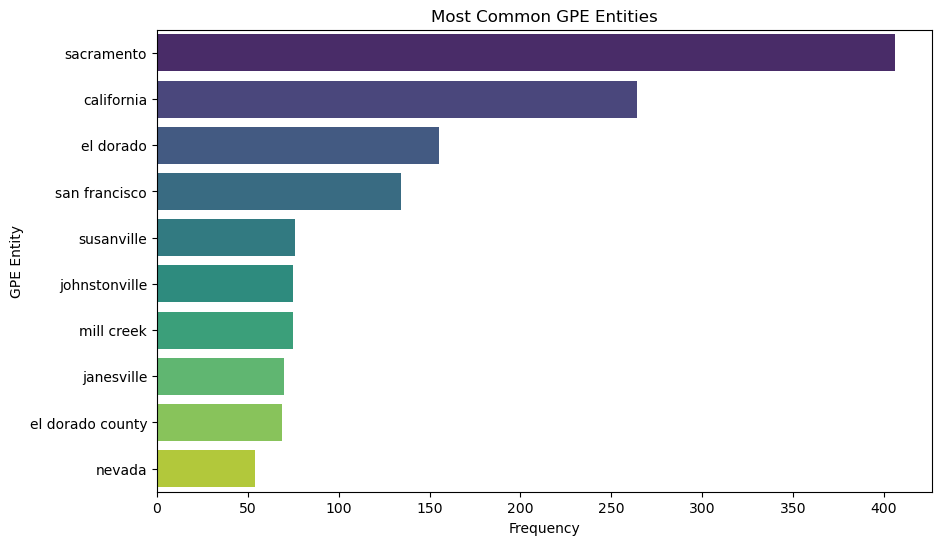

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the NER results
ner_df = pd.read_csv('ner_results.csv')

# Filter the NER results for GPE entities
gpe_entities = ner_df[ner_df['Label'] == 'GPE']

# Count the occurrences of each GPE entity
gpe_counts = gpe_entities['Entity'].value_counts().head(10)

# Display the most common GPE entities
print("Most common GPE entities:")
print(gpe_counts)

# Create a bar plot of the most common GPE entities
plt.figure(figsize=(10, 6))
sns.barplot(x=gpe_counts.values, y=gpe_counts.index, palette='viridis')
plt.title('Most Common GPE Entities')
plt.xlabel('Frequency')
plt.ylabel('GPE Entity')
plt.show()


C:\Users\lucap\AppData\Local\Temp\ipykernel_51128\3738850336.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gpe_counts.values, y=gpe_counts.index, palette='viridis')


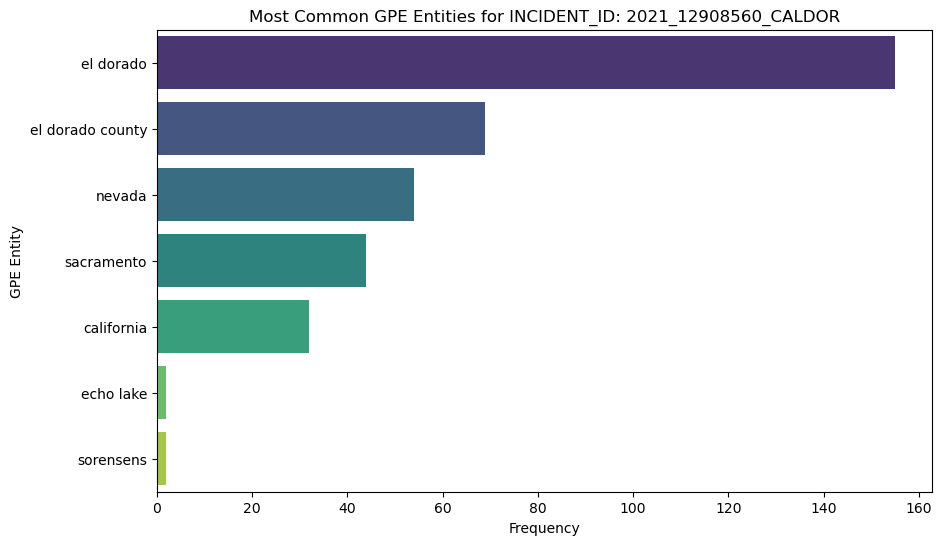

C:\Users\lucap\AppData\Local\Temp\ipykernel_51128\3738850336.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gpe_counts.values, y=gpe_counts.index, palette='viridis')


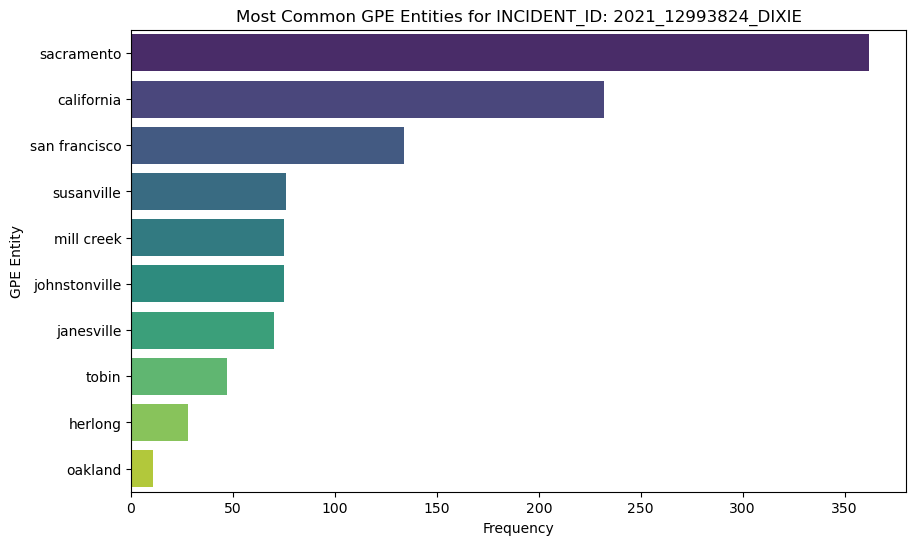

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the NER results
ner_df = pd.read_csv('ner_results.csv')

# Filter the NER results for GPE entities
gpe_entities = ner_df[ner_df['Label'] == 'GPE']

# Get unique INCIDENT_IDs
incident_ids = gpe_entities['INCIDENT_ID'].unique()

# Create a plot for each INCIDENT_ID
for incident_id in incident_ids:
    # Filter the GPE entities for the current INCIDENT_ID
    gpe_entities_incident = gpe_entities[gpe_entities['INCIDENT_ID'] == incident_id]
    
    # Count the occurrences of each GPE entity
    gpe_counts = gpe_entities_incident['Entity'].value_counts().head(10)
    
    # Plot the most common GPE entities
    plt.figure(figsize=(10, 6))
    sns.barplot(x=gpe_counts.values, y=gpe_counts.index, palette='viridis')
    plt.title(f'Most Common GPE Entities for INCIDENT_ID: {incident_id}')
    plt.xlabel('Frequency')
    plt.ylabel('GPE Entity')
    plt.show()


C:\Users\lucap\AppData\Local\Temp\ipykernel_51128\3615188343.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gpe_counts.values, y=gpe_counts.index, palette='viridis')


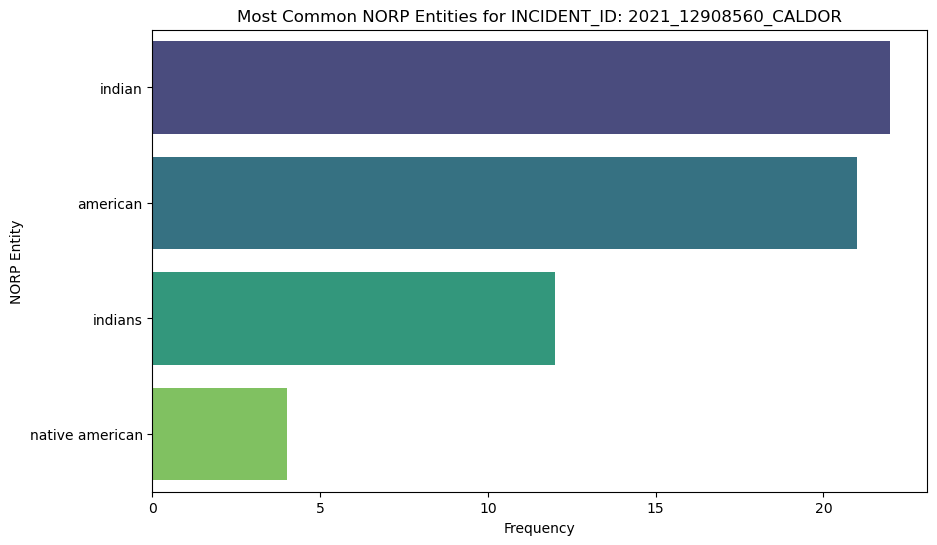

C:\Users\lucap\AppData\Local\Temp\ipykernel_51128\3615188343.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gpe_counts.values, y=gpe_counts.index, palette='viridis')


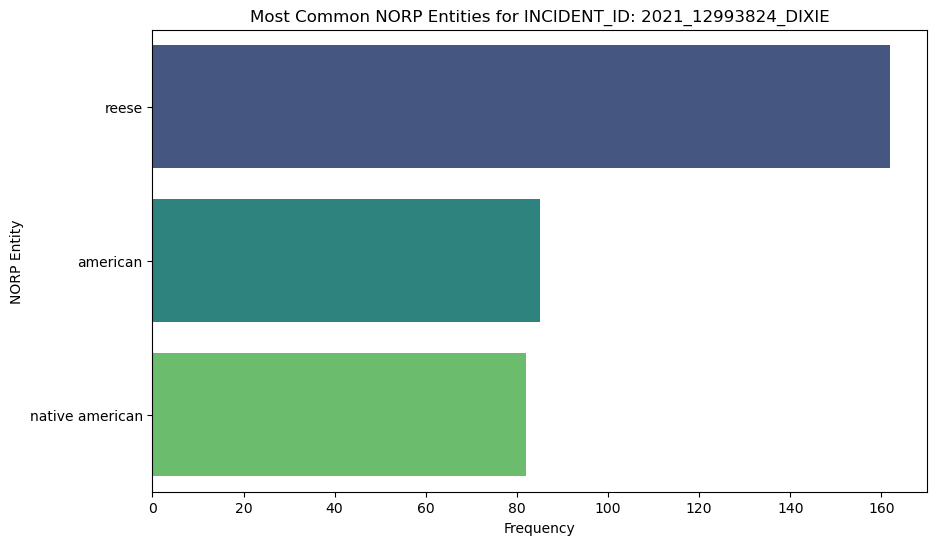

In [20]:
# Filter the NER results for GPE entities
gpe_entities = ner_df[ner_df['Label'] == 'NORP']

# Get unique INCIDENT_IDs
incident_ids = gpe_entities['INCIDENT_ID'].unique()

# Create a plot for each INCIDENT_ID
for incident_id in incident_ids:
    # Filter the GPE entities for the current INCIDENT_ID
    gpe_entities_incident = gpe_entities[gpe_entities['INCIDENT_ID'] == incident_id]
    
    # Count the occurrences of each GPE entity
    gpe_counts = gpe_entities_incident['Entity'].value_counts().head(10)
    
    # Plot the most common GPE entities
    plt.figure(figsize=(10, 6))
    sns.barplot(x=gpe_counts.values, y=gpe_counts.index, palette='viridis')
    plt.title(f'Most Common NORP Entities for INCIDENT_ID: {incident_id}')
    plt.xlabel('Frequency')
    plt.ylabel('NORP Entity')
    plt.show()

In [22]:
from spacy import displacy
nlp = spacy.load("en_core_web_sm")
doc = nlp("This is a test for Dixie fire.")
displacy.render(doc, style="dep")

In [25]:
text = """12 Hours: evacuation in place for area 1.5 miles around the fire. 
impacting campgrounds and dispersed camping. 
potential impacts on utility infrastructure including pg&e distribution lines.  
cosumnes watershed; a critical & high value natural flowing watershed.  
goshawk and spotted owl pacs & california red-legged frog critical habitat. 
native american and historic cultural sites.  
potential impacts to class 1 airshed to the east"""
doc = nlp(text)
sentence_spans = list(doc.sents)
displacy.render(sentence_spans, style="ent")

c:\Users\lucap\miniconda3\envs\earth-analytics-python\lib\site-packages\spacy\displacy\__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [26]:
text = """communities at risk: significant threat and potential devastation (greater than 75 percent of community loss)
to the communities of: sly park, sierra springs, sly park, sierra springs, sly park hills, somerset, pleasant valley, 
grizzly flats, leoni meadows, pollock pines, spring valley, camino, cedar grove 
infrastructure:threats to powerlines and/or electrical distribution:- in the area in and around the caldor fire, 
in el dorado county, pg&e's sierra division, pg&e has numerous assets and critical infrastructure. 
these assets provide power to thousands of customers in el dorado and the surrounding counties. 
these assets include overhead distributions lines and associated equipment (transformers, line reclosers, sectionalizers, etc.),
overhead transmission lines, and associated equipment (poles, steel lattice towers, line reclosers, etc.), 
the el dorado power house hydro-facility and associated equipment. additional pg&e assets include distribution substations, 
telecommunications towers, fiber optic resources.domestic water systems: - the grizzly flats water district has been heavily 
impacted by the fire. the el dorado irrigation district is impacted with the resa and res1 water treatment plants threatened. 
the el dorado canal transports surface water and has apx 2 miles of wood flumes threatened. closure of the canal would result 
in loss of domestic water supply to apx 175-200k population.communication grid- fiber-optic infrastructure runs along the hwy 50 corridor.
transportation - impacts to trans-sierra interstate travel and important evacuation routes with potential impact to hwy 50.  
current closures of improved roadways. historical and significant cultural resources:- significant archaeological native american sites, 
historic cultural sites, and historical structures.natural resources- threatened and endangered (te) state and/or federally listed species
that are threatened by the caldor incident include foothill yellow-legged frog, california red-legged frog, 
sierra nevada yellow-legged frog, great grey owl, and sierra nevada red fox. 
critical habitats for these species are also being threatened.
the cosumnes watershed is a critical & high-value natural flowing watershed. 
potential impacts to class 1 airshed to the east Â¿ mokelumne.
commercial resources- private businesses, commercial timberlands (sierra pacific industries), vineyards, 
and other agricultural lands are threatened and/or impacted.economic impact- tourism impact with camping, hiking, hunting, 
boating, fishing & horseback riding sites threatened. potential loss of jobs to local businesses, vineyards, and wineries."""
doc = nlp(text)
sentence_spans = list(doc.sents)
displacy.render(sentence_spans, style="ent")